# HMM POS Tagging with Viterbi Decoding


## Dependencies


In [1]:
# Download the required data (run this only once)
import nltk
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

## Start
For re-running the code, run from this cell

In [2]:
%reset -f

## Imports

In [3]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import brown
from tqdm.notebook import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

sns.set_theme()

## Constants

In [4]:
SEED = 0

In [5]:
def setSeed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [6]:
setSeed(SEED) # to ensure reproducibility

## Functions

### Utils

In [7]:
mean = lambda l : sum(l) / len(l) # computes the mean of a list

In [8]:
def log(x):
    # Used for calculating log probabilities and handles the error when the input is 0
    if x == 0:
        return -np.inf
    else:
        return np.log(x)

In [9]:
def plotCM(cm):
    # Plots the confusion matrix provided as a numpy array
    df_cm = pd.DataFrame(cm, index = [t for t in TAGS[1:]], columns = [t for t in TAGS[1:]])
    plt.figure(figsize = (15, 10))
    sns.heatmap(df_cm, annot = True, cmap = plt.cm.Blues)
    plt.show()

In [10]:
def printClasswise(metrics):
    # Pretty-printer for the classwise metrics
    for i in range(N_TAGS - 1):
        print(f"{TAGS[i+1]}: {metrics[i]:.3f}", end = ", ")
    print()

### Data

In [11]:
def load():
    # Loads the Brown corpus and converts it into a list
    data = brown.tagged_sents(tagset = "universal") # of type nltk.corpus.reader.util.ConcatenatedCorpusView, each element is a list
    data = list(data) # convert to list for easier processing
    return data

In [12]:
def preprocess(data):
    # Append (^, -) to each data point to indicate the start of a sentence / POS tag sequence
    for s in data:
        s.insert(0, ("^", "-")) # '^' for sentence, '-' for tag

In [13]:
def createFolds(data, k):
    # Randomly shuffles the data and returns k equal sized segments for k-fold cross validation
    n = len(data)
    n_split = n // k # approx split size
    random.shuffle(data)
    folds = []
    for start in range(0, n, n_split):
        end = min(start + n_split, n)
        fold = data[start : end]
        folds.append(fold)
    return folds

In [14]:
def getSentence(d):
    # Given data point d print the sentence contained in it
    s = " ".join([i[0] for i in d])
    return s

In [15]:
def getTags(d):
    # Given data point d return the tag sequence
    t = " ".join([i[1] for i in d])
    return t

In [16]:
def buildTags(data):
    # Compute the set of unique tags present in the data
    tags = set()
    for s in data:
        for w, t in s:
            tags.add(t)
    tags = sorted(list(tags))
    return tags

In [17]:
def buildVocab(data):
    # Compute the set of unique words present in the data, lowercasing is not applied
    vocab = set()
    for s in data:
        for w, t in s:
            vocab.add(w)
    vocab = sorted(list(vocab))
    return vocab

### Model

#### HMM

In [18]:
def buildFreqs(data):
    # Computes the frequency matrices for tags, (tag, tag) and (tag, word)

    tf = defaultdict(int) # when the key doesn't exist in the dict, defaultdict automatically initializes it to 0, unlike normal dicts
    ef = defaultdict(int)
    tag_freq = defaultdict(int)

    for s in data:
        p = "-" # the initial value of the previous tag (this acts as the tag for ^: the sentence start)
        for w, t in s:
            tf[(p, t)] += 1 # auto-init to 0 when key doesn't exit
            ef[(t, w)] += 1 # each word has a corresponding tag
            tag_freq[t] += 1
            p = t # update prev tag

    return tf, ef, tag_freq

In [19]:
def buildMatrices(tf, ef, tag_freq):
    # Builds the transition and emmission matrices from the frequency matrices while applying smoothing 

    # Initialize
    tm = np.zeros((N_TAGS, N_TAGS))
    em = np.zeros((N_TAGS, N_VOCAB))

    alpha = 1e-8 # handles values when certain combinations of tags / bigrams don't occur in the data
    # Reference for this: http://ivan-titov.org/teaching/nlmi-15/lecture-4.pdf

    for i in range(N_TAGS):

        # Build the transition matrix
        for j in range(N_TAGS):
            ti = id2tag(i)
            tj = id2tag(j)
            tm[i, j] = (tf[(ti, tj)] + alpha) / (tag_freq[ti] + alpha*N_TAGS)

        # Build the mmission matrix
        for j in range(N_VOCAB):
            ti = id2tag(i)
            wj = id2word(j)
            em[i, j] = (ef[(ti, wj)] + alpha) / (tag_freq[ti] + alpha*N_VOCAB)

    return tm, em

In [20]:
def train(data):
    # Just runs the past two functions one after the other and returns the transition and emmission matrices
    tf, ef, tag_freq = buildFreqs(data)
    tm, em = buildMatrices(tf, ef, tag_freq)
    return tm, em

In [21]:
def viterbi(tm, em, s):
    # Performs viterbi decoding on sentence s, which is assumed to be a list of words starting from ^
    # Follows the pseudo-code given in the slides

    n_sent = len(s) # length of the sentence to be decoded

    # Create tables to be used for dynamic programming
    best_probs = np.zeros((n_sent, N_TAGS)) # stores the log probabilities to ensure values don't become too small by repeated multiplications later
    best_tags  = np.zeros((n_sent, N_TAGS))

    # Initialize the first row of best_probs
    for i in range(N_TAGS):
        best_probs[0, i] = log(tm[0, i]) + log(em[i, word2id(s[0])])

    # This can be thought of as a "forward pass"
    for i in range(1, n_sent):

        w_prev = s[i - 1]
        w = s[i]

        for j in range(N_TAGS):
            pmax = -np.inf
            best_tag = None # stores index of the best tag for the current word
            for k in range(N_TAGS):        
                p = best_probs[i - 1, k] + log(tm[k, j])
                if p > pmax:
                    pmax = p
                    best_tag = k

            try:
                wid = word2id(w)
            except KeyError: # handles KeyError
                wid = -1 # word not in vocab

            if wid != -1:
                best_probs[i, j] = pmax + log(em[j, wid]) # the second term is constant when taking argmax over k
            else:
                # In this case the bigram doesn't occur in the training data
                best_probs[i, j] = pmax + log(em.min()) # assign the minimum emmission probability to this tag

            best_tags[i, j] = best_tag

    pred = [] # the tag predictions for the sentence

    # Get the last tag 
    pmax = -np.inf
    end_tag = None
    for i in range(N_TAGS):
        if best_probs[-1, i] > pmax:
            pmax = best_probs[-1, i]
            end_tag = i
    pred.append(end_tag)

    # Now backtrack to the start following the path which led to end_tag
    # This can be thought of as a "backward pass"
    t = end_tag # init
    for i in range(n_sent - 1, 1, -1):
        t = int(best_tags[i, t])
        pred.append(t)

    pred.reverse() # as we have built this starting from the back

    return pred

In [22]:
def evaluate(data, tm, em):
    # Evaluates the trained HMM model on the data

    tags_true = []
    tags_pred = []

    for d in tqdm(data):
        s = [i[0] for i in d]
        t_true = [tag2id(i[1]) for i in d[1:]] # ignoring "-" at the start
        t_pred = viterbi(tm, em, s)
        tags_true += t_true
        tags_pred += t_pred
        
    return tags_true, tags_pred

## Main

### Data

In [23]:
# Load the required data
data = load()
preprocess(data)

N = len(data)
print(f"Length: {N:,}")

Length: 57,340


In [24]:
TAGS = buildTags(data)
N_TAGS = len(TAGS)
print(f"Tagset size: {N_TAGS} (includes the dummy '-' tag)")
print(TAGS)

# Maps
id2tag = lambda i : TAGS[i]
tagmap = {TAGS[i]:i for i in range(N_TAGS)}
tag2id = lambda i : tagmap[i]

Tagset size: 13 (includes the dummy '-' tag)
['-', '.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [25]:
# Print some random statements and the corresponding tags
for i in random.sample(range(N), 5):
    print(getSentence(data[i]))
    print(getTags(data[i]))
    print()

^ Eddie shouted .
- NOUN VERB .

^ We therefore leave the writer to the enjoyment of the unenvied reputation which the personal abuse he has heaped on us will entitle him to from the low and vulgar herd to which he belongs '' .
- PRON ADV VERB DET NOUN ADP DET NOUN ADP DET ADJ NOUN DET DET ADJ NOUN PRON VERB VERB ADP PRON VERB VERB PRON ADP ADP DET ADJ CONJ ADJ NOUN ADP DET PRON VERB . .

^ Lots of throttle .
- NOUN ADP NOUN .

^ The major areas of self-help are the following : ( A ) the effective mobilizing of resources .
- DET ADJ NOUN ADP NOUN VERB DET NOUN . . DET . DET ADJ VERB ADP NOUN .

^ Some Dallas investment firms got only 100 shares , for all of their customers .
- DET NOUN NOUN NOUN VERB ADJ NUM NOUN . ADP PRT ADP DET NOUN .



### Training and testing loop

In [26]:
folds = createFolds(data, k = 5)

In [27]:
# Initialize the metrics

# Avg cm
avg_cm = 0 # ignoring the dummy tag added at the start of each sentence

# Initialize average metrics
avg_acc = 0
avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_f05 = 0
avg_f2 = 0

# Average tagwise metrics
avg_prec_tagwise = 0
avg_rec_tagwise = 0
avg_f1_tagwise = 0

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.920, ADP: 0.950, ADV: 0.906, CONJ: 0.995, DET: 0.969, NOUN: 0.962, NUM: 0.969, PRON: 0.952, PRT: 0.911, VERB: 0.973, X: 0.801, 
Tag-wise recall:
.: 1.000, ADJ: 0.910, ADP: 0.969, ADV: 0.895, CONJ: 0.994, DET: 0.987, NOUN: 0.953, NUM: 0.911, PRON: 0.984, PRT: 0.911, VERB: 0.951, X: 0.513, 
Tag-wise F1:
.: 0.998, ADJ: 0.915, ADP: 0.959, ADV: 0.901, CONJ: 0.994, DET: 0.978, NOUN: 0.957, NUM: 0.939, PRON: 0.968, PRT: 0.911, VERB: 0.962, X: 0.625, 
Accuracy: 0.9589936600066015
Avg. precision: 0.9419098515672353
Avg. recall: 0.9148088722896589
Avg. f_0.5: 0.9344649717766362
Avg. f1: 0.9255961113629804
Avg. f2: 0.9186573432271503


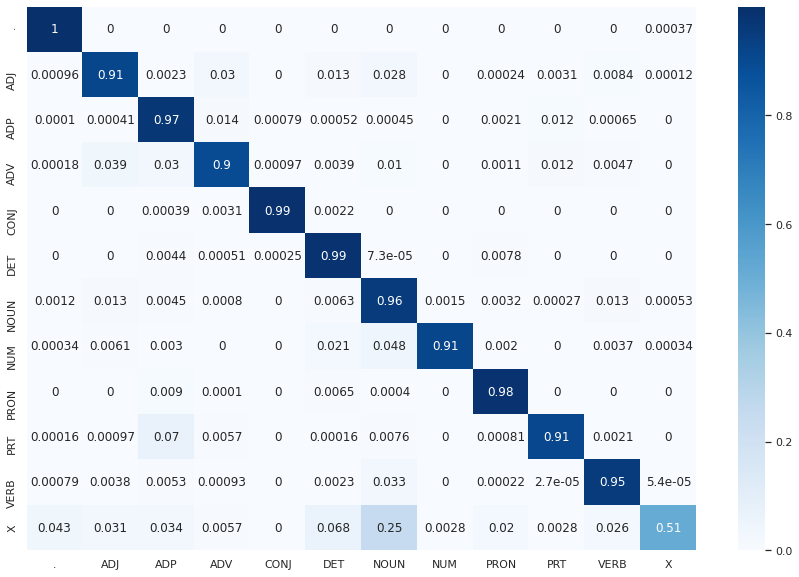

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.925, ADP: 0.949, ADV: 0.913, CONJ: 0.992, DET: 0.967, NOUN: 0.961, NUM: 0.972, PRON: 0.957, PRT: 0.905, VERB: 0.973, X: 0.792, 
Tag-wise recall:
.: 1.000, ADJ: 0.913, ADP: 0.970, ADV: 0.901, CONJ: 0.993, DET: 0.988, NOUN: 0.954, NUM: 0.915, PRON: 0.986, PRT: 0.905, VERB: 0.949, X: 0.412, 
Tag-wise F1:
.: 0.998, ADJ: 0.919, ADP: 0.959, ADV: 0.907, CONJ: 0.992, DET: 0.977, NOUN: 0.958, NUM: 0.942, PRON: 0.971, PRT: 0.905, VERB: 0.961, X: 0.542, 
Accuracy: 0.9596179027583986
Avg. precision: 0.9418731277453681
Avg. recall: 0.9070473367539288
Avg. f_0.5: 0.9308791708662784
Avg. f1: 0.91933345889291
Avg. f2: 0.9112411855153416


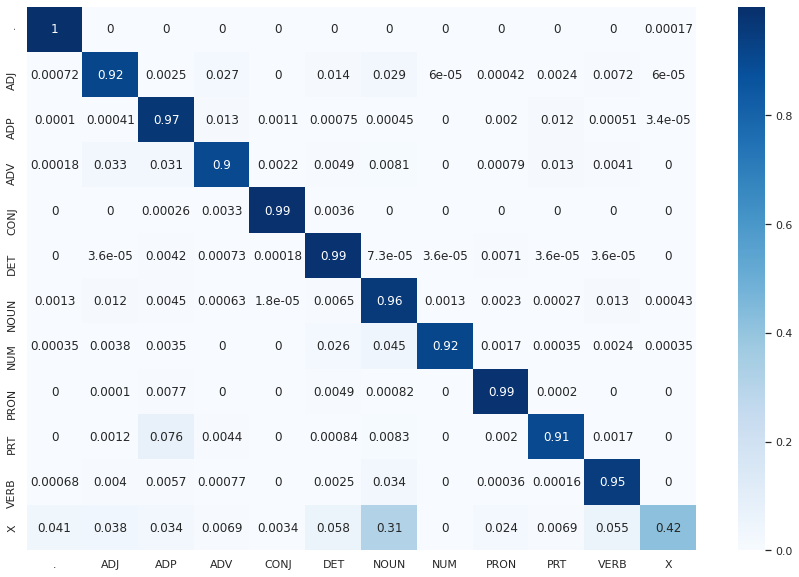

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.920, ADP: 0.952, ADV: 0.909, CONJ: 0.993, DET: 0.968, NOUN: 0.963, NUM: 0.970, PRON: 0.952, PRT: 0.906, VERB: 0.970, X: 0.805, 
Tag-wise recall:
.: 1.000, ADJ: 0.912, ADP: 0.968, ADV: 0.894, CONJ: 0.997, DET: 0.986, NOUN: 0.951, NUM: 0.910, PRON: 0.985, PRT: 0.907, VERB: 0.954, X: 0.552, 
Tag-wise F1:
.: 0.998, ADJ: 0.916, ADP: 0.960, ADV: 0.902, CONJ: 0.995, DET: 0.977, NOUN: 0.957, NUM: 0.939, PRON: 0.968, PRT: 0.907, VERB: 0.962, X: 0.655, 
Accuracy: 0.9590114474863802
Avg. precision: 0.9419899787525474
Avg. recall: 0.9178783834882934
Avg. f_0.5: 0.9356630037234779
Avg. f1: 0.9278330549041852
Avg. f2: 0.9214838229737731


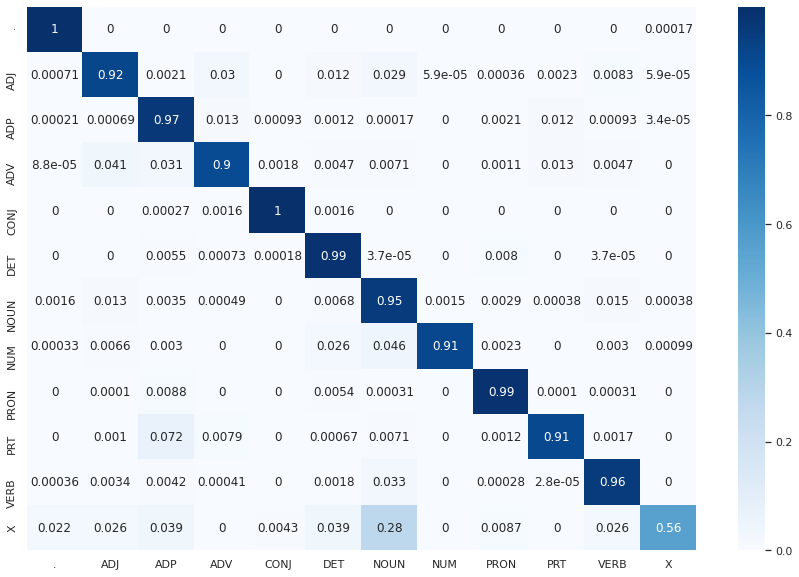

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.996, ADJ: 0.918, ADP: 0.952, ADV: 0.910, CONJ: 0.992, DET: 0.967, NOUN: 0.961, NUM: 0.968, PRON: 0.956, PRT: 0.910, VERB: 0.972, X: 0.890, 
Tag-wise recall:
.: 1.000, ADJ: 0.909, ADP: 0.967, ADV: 0.897, CONJ: 0.995, DET: 0.987, NOUN: 0.952, NUM: 0.917, PRON: 0.985, PRT: 0.913, VERB: 0.951, X: 0.483, 
Tag-wise F1:
.: 0.998, ADJ: 0.914, ADP: 0.960, ADV: 0.904, CONJ: 0.994, DET: 0.977, NOUN: 0.957, NUM: 0.942, PRON: 0.970, PRT: 0.911, VERB: 0.962, X: 0.626, 
Accuracy: 0.9591551126516464
Avg. precision: 0.9494440698013094
Avg. recall: 0.9130694160751561
Avg. f_0.5: 0.9381697469734305
Avg. f1: 0.926103233358735
Avg. f2: 0.9175352552921655


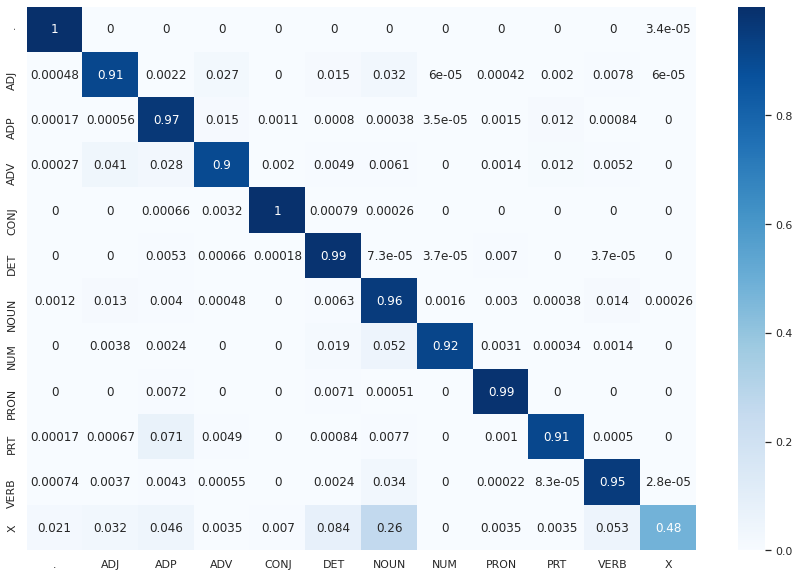

  0%|          | 0/11468 [00:00<?, ?it/s]

Tag-wise precision:
.: 0.995, ADJ: 0.920, ADP: 0.949, ADV: 0.906, CONJ: 0.993, DET: 0.968, NOUN: 0.963, NUM: 0.975, PRON: 0.952, PRT: 0.905, VERB: 0.972, X: 0.730, 
Tag-wise recall:
.: 1.000, ADJ: 0.912, ADP: 0.968, ADV: 0.891, CONJ: 0.995, DET: 0.987, NOUN: 0.952, NUM: 0.913, PRON: 0.985, PRT: 0.899, VERB: 0.951, X: 0.507, 
Tag-wise F1:
.: 0.998, ADJ: 0.916, ADP: 0.958, ADV: 0.899, CONJ: 0.994, DET: 0.978, NOUN: 0.958, NUM: 0.943, PRON: 0.968, PRT: 0.902, VERB: 0.962, X: 0.598, 
Accuracy: 0.9589955635956411
Avg. precision: 0.9358102307869706
Avg. recall: 0.9133270550668029
Avg. f_0.5: 0.9300133602627714
Avg. f1: 0.922742847060281
Avg. f2: 0.9167612940653022


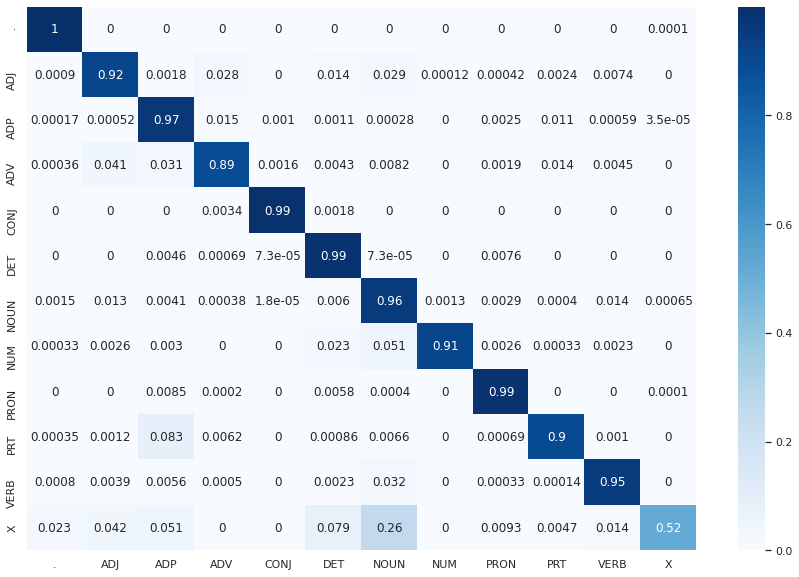

In [28]:
# Start cross-validation

for fv in range(5):

    # Separate out the validation fold
    val_data = folds[fv]

    # Concatenate the training folds
    train_data = []
    for ft in range(5):
        if ft != fv:
            train_data += folds[ft]

    # Update vocab based on training data (these variables are used globally)
    VOCAB = buildVocab(train_data)
    N_VOCAB = len(VOCAB)
    id2word = lambda i : VOCAB[i]
    wordmap = {VOCAB[i]:i for i in range(N_VOCAB)}
    word2id = lambda i : wordmap[i]

    # Train
    tm, em = train(train_data)

    # Validate
    tags_true, tags_pred = evaluate(val_data, tm, em)

    # Compute metrics

    metric_labels = [i+1 for i in range(N_TAGS - 1)] # ignore the first dummy tag '-'

    cm = confusion_matrix(tags_true, tags_pred, normalize = "true", labels = metric_labels)
    acc = accuracy_score(tags_true, tags_pred)

    prec = precision_score(tags_true, tags_pred, average = None, labels = metric_labels)
    rec = recall_score(tags_true, tags_pred, average = None, labels = metric_labels)
    f1 = f1_score(tags_true, tags_pred, average = None, labels = metric_labels)

    f05 = fbeta_score(tags_true, tags_pred, beta = 0.5, average = "macro", labels = metric_labels)
    f2 = fbeta_score(tags_true, tags_pred, beta = 2, average = "macro", labels = metric_labels)

    # Tag-wise metrics
    print("Tag-wise precision:")
    printClasswise(prec)

    print("Tag-wise recall:")
    printClasswise(rec)

    print("Tag-wise F1:")
    printClasswise(f1)

    # Overall metrics for this fold
    print("Accuracy:", acc)
    print("Avg. precision:", mean(prec))
    print("Avg. recall:", mean(rec))
    print("Avg. f_0.5:", f05)
    print("Avg. f1:", mean(f1))
    print("Avg. f2:", f2)

    plotCM(cm)

    # Update global avg values
    avg_acc += acc
    avg_prec += mean(prec)
    avg_rec += mean(rec)
    avg_f1 += mean(f1)
    avg_f05 += f05
    avg_f2 += f2

    # Update tagwise metrics
    avg_prec_tagwise += prec
    avg_rec_tagwise += rec
    avg_f1_tagwise += f1

    # Update cm
    avg_cm += cm

In [29]:
# Average over the number of folds

avg_cm /= 5

avg_acc /= 5
avg_prec /= 5
avg_rec /= 5
avg_f1 /= 5
avg_f05 /= 5
avg_f2 /= 5

avg_prec_tagwise /= 5
avg_rec_tagwise /= 5
avg_f1_tagwise /= 5

Tag-wise precision:
.: 0.996, ADJ: 0.921, ADP: 0.950, ADV: 0.909, CONJ: 0.993, DET: 0.968, NOUN: 0.962, NUM: 0.971, PRON: 0.954, PRT: 0.908, VERB: 0.972, X: 0.804, 
Tag-wise recall:
.: 1.000, ADJ: 0.911, ADP: 0.968, ADV: 0.896, CONJ: 0.995, DET: 0.987, NOUN: 0.952, NUM: 0.913, PRON: 0.985, PRT: 0.907, VERB: 0.951, X: 0.493, 
Tag-wise F1:
.: 0.998, ADJ: 0.916, ADP: 0.959, ADV: 0.902, CONJ: 0.994, DET: 0.977, NOUN: 0.957, NUM: 0.941, PRON: 0.969, PRT: 0.907, VERB: 0.962, X: 0.609, 
Accuracy: 0.9591547372997337
Avg. precision: 0.9422054517306861
Avg. recall: 0.913226212734768
Avg. f_0.5: 0.9338380507205188
Avg. f1: 0.9243217411158182
Avg. f2: 0.9171357802147465


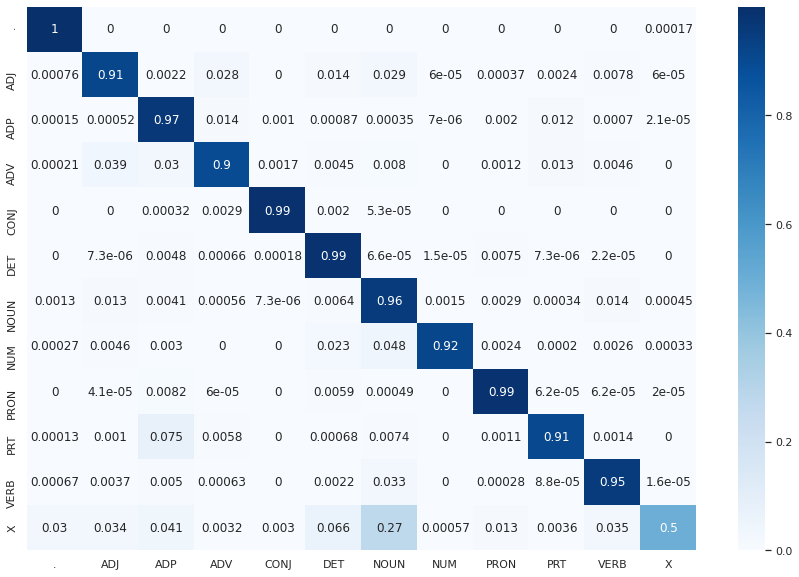

In [30]:
# Final metrics reported

# Tag-wise metrics
print("Tag-wise precision:")
printClasswise(avg_prec_tagwise)

print("Tag-wise recall:")
printClasswise(avg_rec_tagwise)

print("Tag-wise F1:")
printClasswise(avg_f1_tagwise)

# Overall metrics for this fold
print("Accuracy:", avg_acc)
print("Avg. precision:", avg_prec)
print("Avg. recall:", avg_rec)
print("Avg. f_0.5:", avg_f05)
print("Avg. f1:", avg_f1)
print("Avg. f2:", avg_f2)

plotCM(avg_cm)